# Modelowanie układów przepływowych
### Sylwester Arabas
### wykład 3 (21.X.2025)

In [1]:
!pip install --quiet open_atmos_jupyter_utils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.0 MB/s eta 0:00:00


In [2]:
from collections.abc import Iterable, Callable
import numpy as np
from matplotlib import pyplot, colors, cm
from open_atmos_jupyter_utils import show_anim

#### 0. umożliwienie operacji typu `i+one`, `i-half` dla `i` typu `slice`:

In [3]:
class Shift():
    def __init__(self, plus: int, minus: int):
        self.plus = plus
        self.minus = minus
    def __radd__(self, arg: slice):
        return slice(arg.start + self.plus, arg.stop  + self.plus)
    def __rsub__(self, arg: slice):
        return slice(arg.start - self.minus, arg.stop  - self.minus)

one = Shift(1, 1)
half = Shift(0, 1)

#### 1. logika rozszerzania zakresu `slice` (np. `extend(slice(0,1), half)`)

In [4]:
def extend(r: slice, n: int | Shift):
    if type(n) == int and n == 1:
        n = one
    return slice((r - n).start, (r + n).stop)

#### 2. permutacje indeksów, schemat numeryczny UPWIND

In [5]:
def pi(d: int, *arg: slice):
    return arg[d], arg[d-1]

def f(psi_l: np.ndarray, psi_r: np.ndarray, C: np.ndarray):
    return ((C + abs(C)) * psi_l + (C - abs(C)) * psi_r) / 2

def upwind(d: int, psi: np.ndarray, C: np.ndarray, i: slice, j: slice):
    return (
        f(psi[pi(d, i,       j)], psi[pi(d, i + one, j)], C[pi(d, i + half, j)]) -
        f(psi[pi(d, i - one, j)], psi[pi(d, i,       j)], C[pi(d, i - half, j)])
    )

#### 3. klasa reprezentująca solwer (pole skalarne `advectee` unoszone przez przepływ `advector`)

In [6]:
class Upwind:
    def __init__(self, grid: Iterable[int], bc: Iterable[type[Callable]], halo=1):
        assert len(grid) == (supported_n_dims := 2)
        self.n = 0
        self.dims = range(supported_n_dims)
        self.ij = tuple(slice(halo, grid[d] + halo) for d in self.dims)
        self.bc = tuple(bc[d](d, self.ij[d], halo) for d in self.dims)
        self.psi = tuple(
            np.empty(tuple(extend(self.ij[d], halo).stop for d in self.dims))
            for n in range(2)
        )
        self.advector = tuple(
            np.empty(tuple(extend(self.ij[d], half).stop for d in self.dims))
            for d in self.dims
        )
        self.halo = halo

    @property
    def advectee(self):
        return self.psi[self.n][self.ij]

    def step(self):
        for d in self.dims:
            self.bc[d](self.psi[self.n], extend(self.ij[d - 1], self.halo))
        self.psi[self.n + 1][self.ij] = self.psi[self.n][self.ij]
        for d in self.dims:
            self.psi[self.n + 1][self.ij] -= upwind(
                d, self.psi[self.n], self.advector[d], *pi(d, *self.ij)
            )
        self.n  = (self.n + 1) % 2 - 2

#### 4. cykliczny (periodyczny) warunek brzegowy




In [7]:
class Cyclic:
    def __init__(self, d: int, i: slice, halo: int):
        self.d = d
        self.left_halo = slice(i.start - halo, i.start       )
        self.rght_edge = slice(i.stop  - halo, i.stop        )
        self.rght_halo = slice(i.stop,         i.stop  + halo)
        self.left_edge = slice(i.start,        i.start + halo)

    def __call__(self, psi: np.ndarray, j: slice):
        psi[pi(self.d, self.left_halo, j)] = psi[pi(self.d, self.rght_edge, j)]
        psi[pi(self.d, self.rght_halo, j)] = psi[pi(self.d, self.left_edge, j)]

#### 5. instancja solwera, określenie warunku początkowego i pola prędkości

In [8]:
solver = Upwind(grid:=(32, 16), bc=(Cyclic, Cyclic))

x = np.linspace(-10, 10, grid[0])
y = np.linspace(-10, 10, grid[1])
x0, y0 = 0, 0
sigma = 2.0

solver.advectee[:] = np.exp(-(
    (x[:, None] - x0)**2 +
    (y[None, :] - y0)**2
) / (2 * sigma**2))

solver.advector[0][:] = .5
solver.advector[1][:] = .25

#### 6. całkowanie w czasie

In [9]:
history = []
for n in range((nt:=44) + 1):
    if n != 0:
        solver.step()
    history.append(solver.advectee.copy())

#### 7. wizualizacja


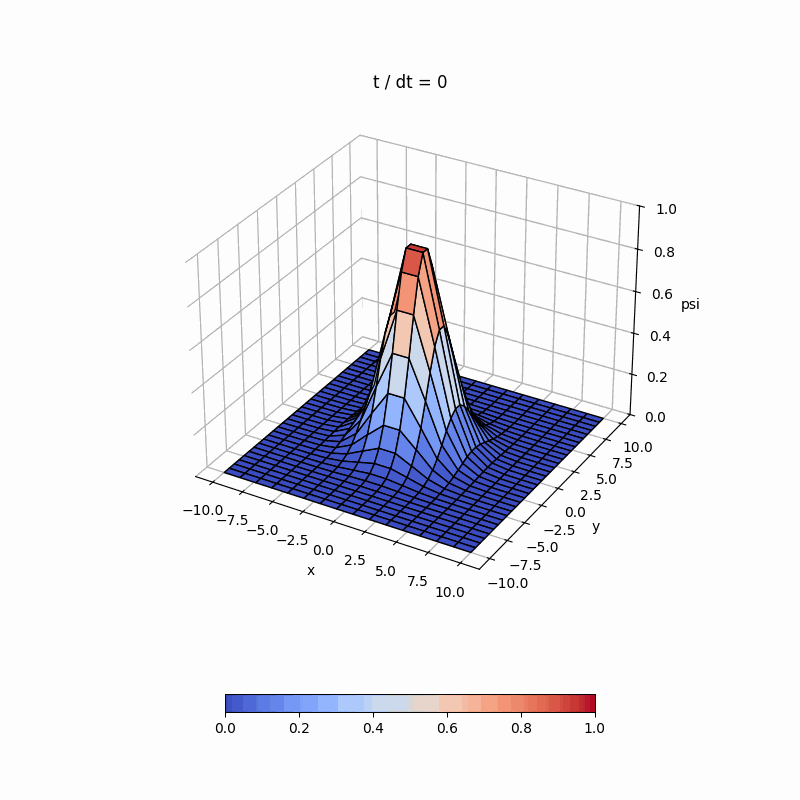

Button(description='tmpjmn33s_b.gif', style=ButtonStyle())

In [10]:
def plot(n, zlim=(0, 1)):
    axs = (fig := pyplot.figure(figsize=(8, 8))).add_subplot(projection="3d")
    axs.set(xlabel="x", zlim=zlim, title=f"t / dt = {n}", ylabel="y", zlabel="psi")
    fig.colorbar(
        axs.plot_surface(
            *np.meshgrid(y, x),
            history[n],
            color='k',
            cmap=cm.coolwarm,
            norm=colors.Normalize(*zlim)
        ),
        fraction=0.03, location='bottom'
    )
    return fig
show_anim(plot, range(len(history)))